# Определение возраста покупателей

Для целей коммерческого использования иформации о возрасте человека (например, создание реккомендательных систем) необходимо построить модель машинного обучения, позволяющую прогонозировать возраст человека на основании изображений - портретной фотографии (например фото из соцсетей, аккаунтов или фотоаватар пользователя в мессенджере).

Исходная информация для обучения: датасет с фотографиями и файлом-описанием, содержащим имя файла фото и реальный возраст человека, изображенного на фотограии.

Проведем исследовательский анализ предоставленной информации, определим наличие аномалий и артефактов в данных, а также необходимость дополнительной обработки изображений.

Создадим тренировочный и тестовый набор графической информации с учетом данных файла-описания.

Построим нейронную сеть для создания модели определения возраста и определим параметры метрики качества модели. Для оценки качества будем использовать MAE (среднюю абсолютную ошибку).

Проведем анализ полученной модели.

## Исследовательский анализ данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

**Ознакомление с файлом-описанием**

Загрузим файл-описание, содержащий наименование файлов изображений и реальные возраст человека, который изображен на фотографии в соответсвующем файле (что соответсвует целевому признак).

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv') #загрузка файла с наименованием изображний и значениями рального возраста

In [3]:
labels.info() #информация о выборке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Проведем анализ показателей файла-описания на педмет наличия пропусков, дубликатов и распределения рельных возрастов в предложенной выборке.

In [4]:
labels.shape #размер выборки 

(7591, 2)

Выборка представляет из себя 7591 запись с именами файов, которые содержат фоторгафии и возраст человека, изображенного на ней. Размер выборки достаточно велик. Однако, если предположить, что на каждое значение возраста приходится одинаковое колличество фотографий, то для прогнозирования конкретного значения возраста приходится всего примерно по 75 фото (из предположений возраста от одного года до ста лет). В реальности же, учитывая неравномерное распределение фото по возрастам, а также индивидальные особенности возрастных черт лица, можно говорить, что колличество фото для определения конкретного возраста не так уж и велико по отдельным значениям.

In [5]:
labels.isna().sum() #проверка на нличие отсутсвующих значений

file_name    0
real_age     0
dtype: int64

Пропуски отсутсвуют.

In [6]:
labels.duplicated().sum() #проверка на наличие дубликатов

0

Дубликаты отсутсвуют.

In [7]:
labels.describe() #описательные статистистики выборки 

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


(array([149.,  88.,  25., 101.,  87.,  68.,  67.,  44.,  34.,  45.,  51.,
         56.,  79., 125., 128., 193., 163., 193., 180., 178., 143., 179.,
        213., 211., 315., 226., 229., 217., 164., 317., 129., 174., 144.,
        156., 147., 122., 144., 124., 107., 167.,  98.,  99.,  85.,  96.,
         88.,  74.,  93.,  66.,  74., 156.,  70.,  76.,  45.,  44.,  51.,
         41.,  37.,  54.,  41.,  75.,  28.,  28.,  20.,  23.,  36.,  18.,
         18.,  15.,  18.,  50.,  10.,  13.,  10.,   6.,  17.,   7.,   8.,
          3.,   6.,  31.,   3.,   5.,   3.,   8.,  12.,   3.,   6.,   3.,
          4.,  21.,   1.,   0.,   1.,   5.,   2.,   2.,   1.,   0.,   0.,
          1.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  22.78,  23.77,
         24.76,  25.75,  26.74,  27.73,  28.72,  29.71,  30.7 ,  31.69,
         32.68,  33.67,  34.66

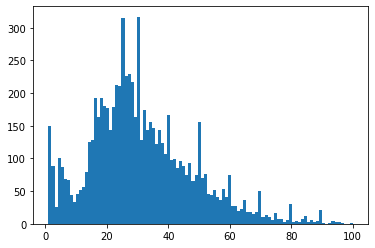

In [8]:
plt.hist(labels['real_age'], bins=100) #построение распределения возрастов в выборке

Выборка сожержит 7591 изображение для возрастов в диапазоне от 1 года до 100 лет. Распределение имеет нормальный характер. Данные слабо смещены влево. Среднее значение - 31 год, медианное - 29.  Присутствуют отдельные выбросы по различным возрастам (1 год, 30, 40, 50, 60, 70, 80, 90 лет), что вероятно можно обяснить тем, что при формировании файла-описания возраст округлялся до десятков лет. Отдельно можно выделить кластер возрастов 1 год -10 лет (аномалия в распределении - количество таких фото достаточно велико для кривой нормально распределения в рассматриваемой части).  50 процентов изображений (2 и 3 квартили) с наибольшим числом значений лежат в диапазоне от 20 до 40 лет. Таким образом, наилучшее качество прогнозирования будет обеспечено моделью обучения именно для этих возрастов.

**Ознакомление с файлами-изображениями**

Для ознакомления с примерами файлов изображения выведем несколько записей с примерами имен файлов их форматом и размером.

In [9]:
for i in range(1001, 6000, 500):
    file = f'/datasets/faces/final_files/00{i}.jpg'
    image = Image.open(file)
    print(f'Имя файла:00{i}.jpg')
    print('Формат файла: ', image.format)
    print('Размер файла: ', image.size)
    print()

Имя файла:001001.jpg
Формат файла:  JPEG
Размер файла:  (371, 370)

Имя файла:001501.jpg
Формат файла:  JPEG
Размер файла:  (117, 116)

Имя файла:002001.jpg
Формат файла:  JPEG
Размер файла:  (658, 659)

Имя файла:002501.jpg
Формат файла:  JPEG
Размер файла:  (194, 194)

Имя файла:003001.jpg
Формат файла:  JPEG
Размер файла:  (352, 352)

Имя файла:003501.jpg
Формат файла:  JPEG
Размер файла:  (152, 151)

Имя файла:004001.jpg
Формат файла:  JPEG
Размер файла:  (165, 165)

Имя файла:004501.jpg
Формат файла:  JPEG
Размер файла:  (169, 169)

Имя файла:005001.jpg
Формат файла:  JPEG
Размер файла:  (341, 341)

Имя файла:005501.jpg
Формат файла:  JPEG
Размер файла:  (235, 235)



Как видно из примера, файлы соответсвуют заявленному формату .jpeg, размер изображений варьируется в достаточно широком диапазоне, однако размерность по вертикали практически идентична размерности по горизонтали для каждого изображения.

Проведем чтение изображений и их сопосталение с именами файлов и значениями возрастов, изображения приведем к одному масштабу.

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255) #загрузка и предобработка изображений
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Выведем примеры полученных изображений.

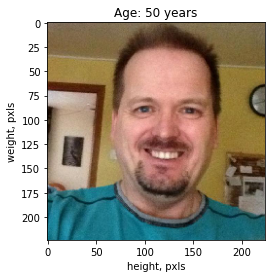

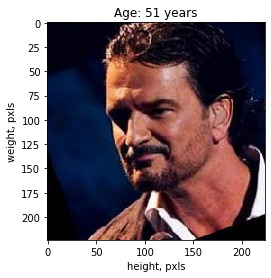

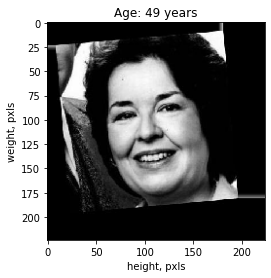

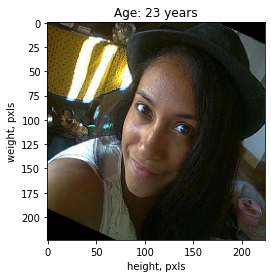

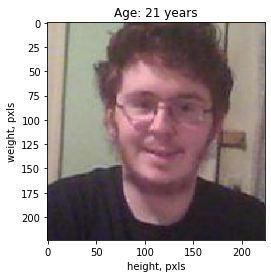

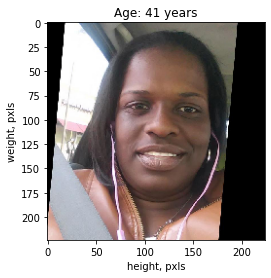

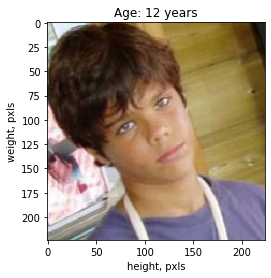

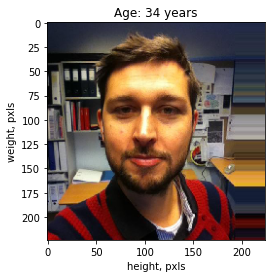

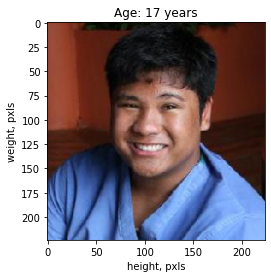

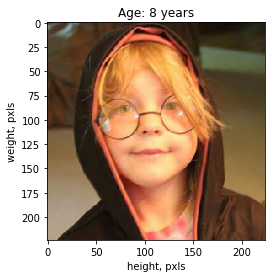

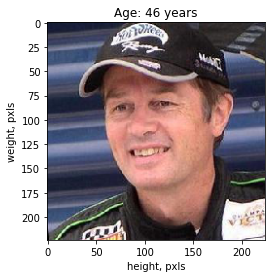

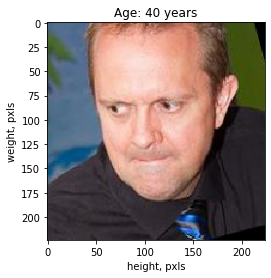

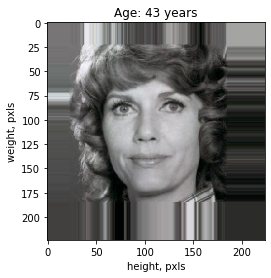

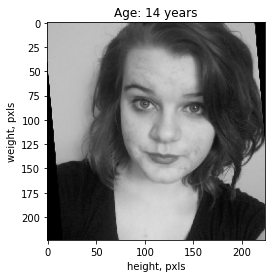

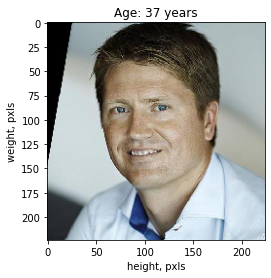

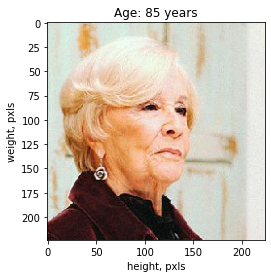

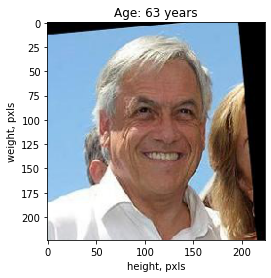

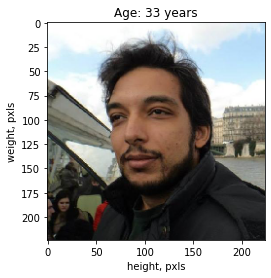

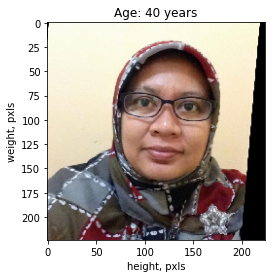

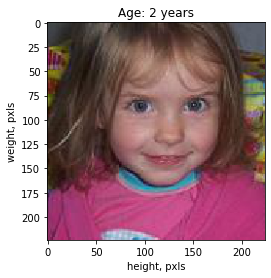

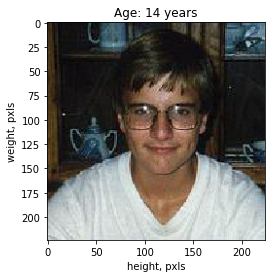

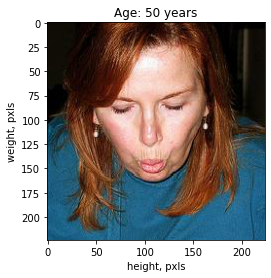

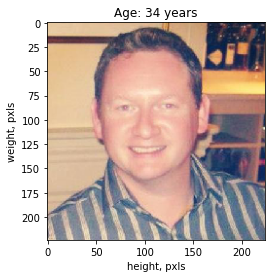

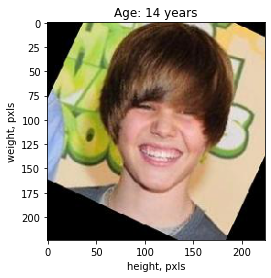

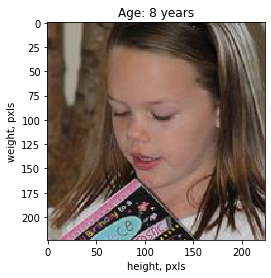

In [11]:
for k in range(0, 5):
    for j in range(0, 5):#вывод приметра изображений
        plt.imshow(train_gen_flow[j][0][k])
        plt.title(f'Age: {train_gen_flow[j][1][k]} years')
        plt.xlabel("height, pxls")
        plt.ylabel("weight, pxls")
        plt.show()

**Вывод**

Представленные в датасете изображения преставляют из себя портретные фотографии с ориентацией лица 'в профиль' или 'три четверти'. Общая ориентация изображений - сверху-вниз (нормальная, видны признаки принудительного изменения ориентации), необходимость поворота отсутсвует. Большинство изображений цветные, однако, часть изображений представлена в оттенках серого. Часть фоторгафий более четкие, часть - размытые, что указывает на различный исходный размер изображений. Повторы и пропуски файлов отсутсвуют. Файлы изображений не требуют дополнительной обработки. Выброка сожержит 7591 изображении для возрастов в диапазоне от 1 года до 100 лет.  Данные слабо смещены влево.50 процентов изображений (2 и 3 квартили) с наибольшим числом значений лежат в диапазоне от 20 до 40 лет, что обеспечит наилучшее прогнозирование указанных значений возраста.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    train_data = train_gen_flow
    return train_data 

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)
    test_data = test_gen_flow
    return test_data

def create_model(input_shape): 
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=32, epochs=15,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=None, epochs=15,
              steps_per_epoch=len(train_data),
              validation_steps=len(test_data),
              verbose=2)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 45s - loss: 10.7484 - mae: 10.7491 - val_loss: 15.9804 - val_mae: 15.9606
Epoch 2/15
178/178 - 38s - loss: 6.9521 - mae: 6.9528 - val_loss: 16.3719 - val_mae: 16.3524
Epoch 3/15
178/178 - 37s - loss: 6.0675 - mae: 6.0678 - val_loss: 13.8945 - val_mae: 13.8528
Epoch 4/15
178/178 - 37s - loss: 5.3569 - mae: 5.3571 - val_loss: 8.5541 - val_mae: 8.5669
Epoch 5/15
178/178 - 37s - loss: 4.8083 - mae: 4.8084 - val_loss: 6.8414 - val_mae: 6.8454
Epoch 6/15
178/178 - 37s - loss: 4.4224 - mae: 4.4226 - val_loss: 6.4934 - val_mae: 6.5070
Epoch 7/15
178/178 - 38s - loss: 4.1439 - mae: 4.1441 - val_loss: 6.7138 - val_mae: 6.7318
Epoch 8/15
178/178 - 37s - loss: 3.8181 - mae: 3.8179 - val_loss: 6.9661 - val_mae: 6.9831
Epoch 9/15
178/178 - 37s - loss: 3.5796 - mae: 3.5798 - val_loss: 6.0237 - val_mae: 6.0432
Epoch 10/15
178/178 - 37s - loss: 3.2952 - mae: 3.2952 - val_loss: 6.1103 - val_mae: 6.0970
Epoch 11/15
178/178 - 37s - loss: 3.1884 - mae: 3.1884 - val_loss: 6.5054 - val_mae: 6.5213
Epoch 12/15
178/178 - 38s - loss: 3.0505 - mae: 3.0502 - val_loss: 6.9647 - val_mae: 7.0018
Epoch 13/15
178/178 - 37s - loss: 2.8500 - mae: 2.8498 - val_loss: 5.9937 - val_mae: 6.0116
Epoch 14/15
178/178 - 37s - loss: 2.7177 - mae: 2.7176 - val_loss: 6.5028 - val_mae: 6.5024
Epoch 15/15
178/178 - 37s - loss: 2.7076 - mae: 2.7076 - val_loss: 5.8876 - val_mae: 5.8875

60/60 - 9s - loss: 5.8876 - mae: 5.8875
Test MAE: 5.8875



## Анализ обученной модели

Созданная модель предсталяет из себя нейронную сеть, сочетающую в себе архитектуру ResNet50 (50 слоев), слой пуллинга GlobalAveragePooling2D() (для оптимизации набора параметров модели), и два последовательных Dense-слоя со 100 и 1 нейроном на выходе (так как созданная модель выполняет задачи регресии) соответсвеено с функцией активации 'relu'. Для повышения качества модели также использована аугментация датасета (горизонтальный флип) и аглоритм автоматического подбора шага градиентного спуска Adam (cо скоростью обучения 0.0001).

Модель позволяет достичь целевой метрики MAE со значением 5.89 (с учетом 15 эпох, целевое значение MAE менее 8 на тестовых данных - уже на 5 эпохе), что означает, что ошибка определения возраста будет составлять примерно 6 лет.

Полученная модель может быть использована для построения рекомедательных систем предложения товаров и услуг, особенно для категорий спроса не имеющих строгого возрастного ценза. Однако, для для товаров и услуг с возрастной маркировкой (особенно 18+) необходимо улучшить точность модели, напрмер, за счет увеличения обучающего датасета.